In [291]:
import gpflow as gpf
import numpy as np
import gpflow.multioutput.kernels as mk
import gpflow.multioutput.features as mf
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import display, Markdown, Latex
tf.logging.set_verbosity(tf.logging.FATAL)
np.set_printoptions(linewidth=100, suppress=True, precision=4)
plt.style.use("slides")

In [182]:
def reformat_data(data, traj_idx_start=0, traj_idx_end=-1, take_every=1):
    states = data['states'][traj_idx_start:traj_idx_end]
    actions = data['actions'][traj_idx_start:traj_idx_end]
    state_dim = states.shape[2]
    action_dim = actions.shape[2]
    s = states[:, :-take_every, :].reshape(-1, state_dim)
    s_next = states[:, take_every:, :].reshape(-1, state_dim)
    if take_every == 1:
        u = actions[:, :, :].reshape(-1, action_dim)
    else:
        u = actions[:, :-(take_every-1), :].reshape(-1, action_dim)
    combined_x = np.concatenate((s, u), axis=1)
    # make data more zero centered by making things relative to the head
    combined_x[:, 0] -= combined_x[:, 4]
    combined_x[:, 2] -= combined_x[:, 4]
    combined_x[:, 4] -= combined_x[:, 4]
    combined_x[:, 1] -= combined_x[:, 5]
    combined_x[:, 3] -= combined_x[:, 5]
    combined_x[:, 5] -= combined_x[:, 5]
    x = s
    # predict the delta only
    y = s_next - s
    return x, y, u, combined_x

In [297]:
data = np.load("240_50_random4.npz")
train_x, train_y, train_u, combined_train_x = reformat_data(data, traj_idx_start=0, traj_idx_end=20, take_every=1)
test_x, test_y, test_u, combined_test_x = reformat_data(data, traj_idx_start=20, traj_idx_end=25, take_every=1)

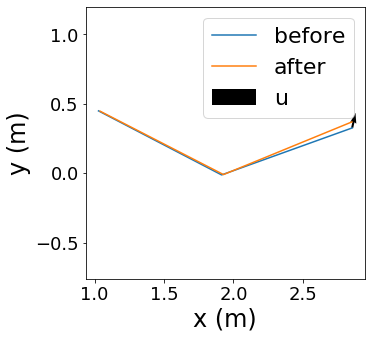

In [298]:
example_idx = 0
plt.figure(figsize=(5,5))
train_x_i = train_x[example_idx]
train_y_i = train_x_i + train_y[example_idx]
train_u_i = train_u[example_idx]
example_xs = [train_x_i[0], train_x_i[2], train_x_i[4]]
example_ys = [train_x_i[1], train_x_i[3], train_x_i[5]]
example_xs_next = [train_y_i[0], train_y_i[2], train_y_i[4]]
example_ys_next = [train_y_i[1], train_y_i[3], train_y_i[5]]

plt.plot(example_xs, example_ys, label='before')
plt.plot(example_xs_next, example_ys_next, label='after')
plt.quiver(train_x_i[4], train_x_i[5], train_u_i[0], train_u_i[1], label='u')

plt.axis("equal")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

### Train one multi-output GP

In [286]:
gpf.reset_default_graph_and_session()
input_dim = 8
output_dim = 6
k = gpf.kernels.RBF(input_dim, ARD=True)
# k = gpf.kernels.Constant(input_dim=4)
# mean = None
mean = gpf.mean_functions.Linear(np.zeros((input_dim,output_dim)), np.zeros((output_dim)))
m = gpf.models.GPR(combined_train_x, train_y, kern=k, mean_function=mean)
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,"(8,)",True,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
GPR/kern/variance,Parameter,None,+ve,True,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,1.0
GPR/mean_function/A,Parameter,None,(none),True,"(8, 6)",True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...."
GPR/mean_function/b,Parameter,None,(none),True,"(6,)",True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [ ]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m);

In [294]:
display(m.as_pandas_table())
print('A=', m.mean_function.A.value[:-2].T)
print('B=', m.mean_function.A.value[-2:].T)
print('C=', m.mean_function.b.value)
print('C=', m.kern.lengthscales.value)

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,"(8,)",True,"[0.18961843990194252, 0.25800709190629634, 0.2..."
GPR/kern/variance,Parameter,None,+ve,True,(),True,0.000268608868165912
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,1.0000037643221872e-06
GPR/mean_function/A,Parameter,None,(none),True,"(8, 6)",True,"[[-0.0057137460111145654, 0.006340294656649899..."
GPR/mean_function/b,Parameter,None,(none),True,"(6,)",True,"[-0.00014438307343369152, -0.00062918290470852..."


A= [[-0.0057 -0.0046  0.0041 -0.0008  0.      0.    ]
 [ 0.0063 -0.0066 -0.0032 -0.0015  0.      0.    ]
 [-0.0022  0.0051 -0.008  -0.0069  0.      0.    ]
 [ 0.001  -0.0033  0.0016 -0.0084  0.      0.    ]
 [ 0.0016  0.0003 -0.0015 -0.      0.      0.    ]
 [-0.0005  0.0021  0.0004  0.0016  0.      0.    ]]
B= [[ 0.028   0.0168]
 [-0.0009  0.0194]
 [ 0.0335  0.0061]
 [-0.0036  0.0406]
 [ 0.0803 -0.0021]
 [ 0.0014  0.0848]]
C= [-0.0001 -0.0006 -0.0048  0.0015 -0.002   0.0003]
C= [0.1896 0.258  0.2403 0.2671 1.     1.     0.0647 1.1033]


In [299]:
def plot_test(model, example_idx, title='', multistep=1):
    test_x_i = test_x[example_idx]
    test_y_i = test_x_i + test_y[example_idx]
    test_u_i = test_u[example_idx]
    
    combined_test_x_i = np.expand_dims(combined_test_x[example_idx], axis=0)
    for ti in range(multistep):
        pred_y_mean_i = combined_test_x_i
        pred_y_mean_i, pred_y_std_i = model.predict_f(combined_test_x_i)
    pred_y_mean_i = test_x_i + pred_y_mean_i[0]
    pred_y_std_i = pred_y_std_i[0]
    
    example_xs = [test_x_i[0], test_x_i[2], test_x_i[4]]
    example_ys = [test_x_i[1], test_x_i[3], test_x_i[5]]
    example_xs_next = [test_y_i[0], test_y_i[2], test_y_i[4]]
    example_ys_next = [test_y_i[1], test_y_i[3], test_y_i[5]]
    pred_xs_mean_next = [pred_y_mean_i[0], pred_y_mean_i[2], pred_y_mean_i[4]]
    pred_ys_mean_next = [pred_y_mean_i[1], pred_y_mean_i[3], pred_y_mean_i[5]]
    z_value = 2.58
    pred_xs_one_std_above_next = [pred_y_mean_i[0], pred_y_mean_i[2], pred_y_mean_i[4]] + z_value * np.array([pred_y_std_i[0], pred_y_std_i[2], pred_y_std_i[4]])
    pred_ys_one_std_above_next = [pred_y_mean_i[1], pred_y_mean_i[3], pred_y_mean_i[5]] + z_value * np.array([pred_y_std_i[1], pred_y_std_i[3], pred_y_std_i[5]])
    pred_xs_one_std_below_next = [pred_y_mean_i[0], pred_y_mean_i[2], pred_y_mean_i[4]] - z_value * np.array([pred_y_std_i[0], pred_y_std_i[2], pred_y_std_i[4]])
    pred_ys_one_std_below_next = [pred_y_mean_i[1], pred_y_mean_i[3], pred_y_mean_i[5]] - z_value * np.array([pred_y_std_i[1], pred_y_std_i[3], pred_y_std_i[5]])
    std_fill_xs = np.hstack((pred_xs_one_std_above_next, pred_xs_one_std_below_next[::-1]))
    std_fill_ys = np.hstack((pred_ys_one_std_above_next, pred_ys_one_std_below_next[::-1]))

    plt.figure(figsize=(10,10))
    plt.plot(example_xs, example_ys, label='before')
    plt.plot(example_xs_next, example_ys_next, label='after')
    plt.plot(pred_xs_mean_next, pred_ys_mean_next, label='pred')
    plt.fill(std_fill_xs, std_fill_ys, label='99% confidence region', alpha=0.4)
    plt.quiver(test_x_i[4], test_x_i[5], test_u_i[0], test_u_i[1], label='u')
    
    plt.axis("equal")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.legend(bbox_to_anchor=(1,1))

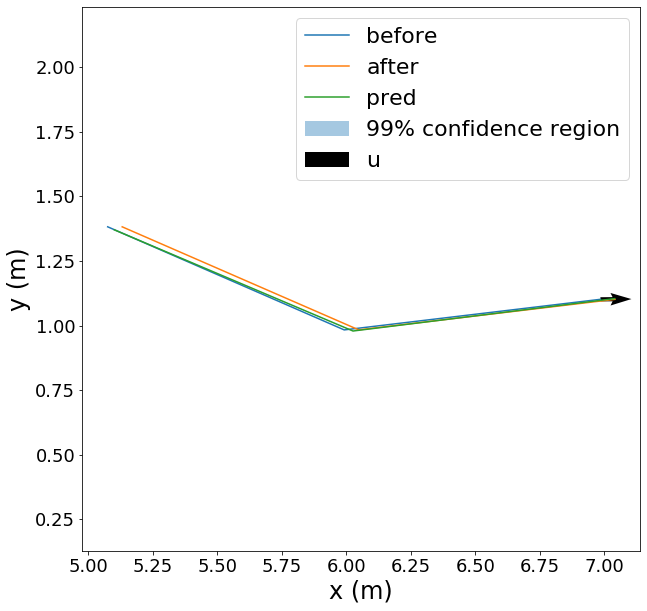

In [304]:
plot_test(m, 10, 'trained')

In [258]:
def mean_total_node_position_error(model):
    """ compute the euclidian distance for each node in pred_y[i] to each node in test_y[i], averaged over all i using the max likelihood prediction"""
    pred_y_mean, pred_y_std = model.predict_f(combined_test_x)
    total_node_error = np.linalg.norm(pred_y_mean[:, 0:2] - test_y[:, 0:2], axis=1) + \
                       np.linalg.norm(pred_y_mean[:, 2:4] - test_y[:, 2:4], axis=1) + \
                       np.linalg.norm(pred_y_mean[:, 4:6] - test_y[:, 4:6], axis=1)
    return total_node_error.mean()
    
    
def mean_likelihood(model):
    """ compute the likelihood of test_y[i] under the prediction for test_x[i], averaged over all i """
    pred_y_mean, pred_y_std = model.predict_density(combined_test_x)
    

In [223]:
mean_total_node_position_error(m)

0.2937552192293184

In [215]:
pred_y_mean, pred_y_std = m.predict_f(combined_test_x)

In [217]:
print(np.linalg.norm(pred_y_mean[0, 0:2]- test_y[0, 0:2]))

0.06514911105017275
